In [1]:
# !pip install pandas==1.5.3
# !pip install numpy==1.26.4
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2
# !pip install shap==0.46.0
# !pip install joblib==1.4.2
# !pip install scikit-learn==1.5.2
# !pip install xgboost==2.1.1
# !pip install lightgbm==4.5.0
# !pip install catboost==1.2.7
# !pip install optuna==4.0.0
# !pip install imbalanced-learn==0.12.3
# !pip install dice-ml==0.11
# !pip install aif360==0.6.1

In [2]:
# add if really needed fow  solsve error warnings
# tensorflow>=2.17.0
# fairlearn>=0.10.0
# inFairness>=0.2.3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from sklearn.calibration import calibration_curve
from scipy.stats import wilcoxon, friedmanchisquare
import joblib
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import optuna
import dice_ml
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

# Configuration for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')  # Changed from 'seaborn-v0_8-paper' to 'default'
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final_enhanced"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS (ENHANCED FOR Q1-Q2 JOURNAL)")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

D:\cons\memek\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


CUSTOMER CHURN PREDICTION ANALYSIS (ENHANCED FOR Q1-Q2 JOURNAL)
Analysis started at: 2025-06-29 16:53:08
Output directory: rill_final_enhanced


In [4]:

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")
except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    print("Make sure the dataset is in the 'dataset/' folder")
    exit()


STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0



STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 0
Final dataset shape: (7043, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5174 (73.46%)
- Yes: 1869 (26.54%)


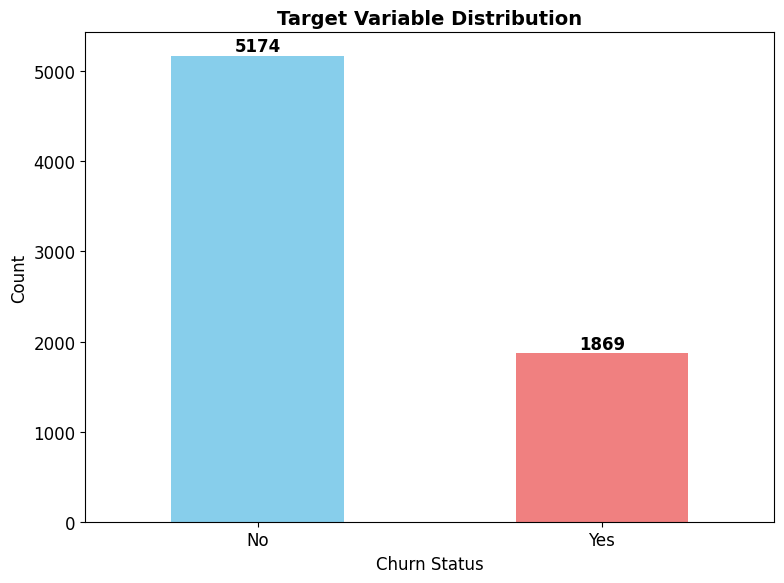

In [5]:
# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    missing_before = df['TotalCharges'].isnull().sum()
    print(f"Missing values in TotalCharges: {missing_before}")

    # Remove rows with missing values
    if missing_before > 0:
        df.dropna(inplace=True)
        print(f"✓ Removed {missing_before} rows with missing values")
else:
    print("TotalCharges column not found")

print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
if 'Churn' not in df.columns:
    print("❌ Churn column not found in dataset")
    print(f"Available columns: {list(df.columns)}")
    exit()

target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()



STEP 3: FEATURE ENGINEERING
✓ Saved dataset copy without feature engineering
✓ Added Engagement_Score feature
✓ Added Churn_Risk_Score feature
✓ Added Service_Utilization feature
✓ Added Payment_Reliability feature
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 34
✓ One-hot encoding completed for dataset without feature engineering
Final feature matrix shape (without FE): (7043, 30)
Final feature matrix shape: (7043, 34)
Target variable shape: (7043,)


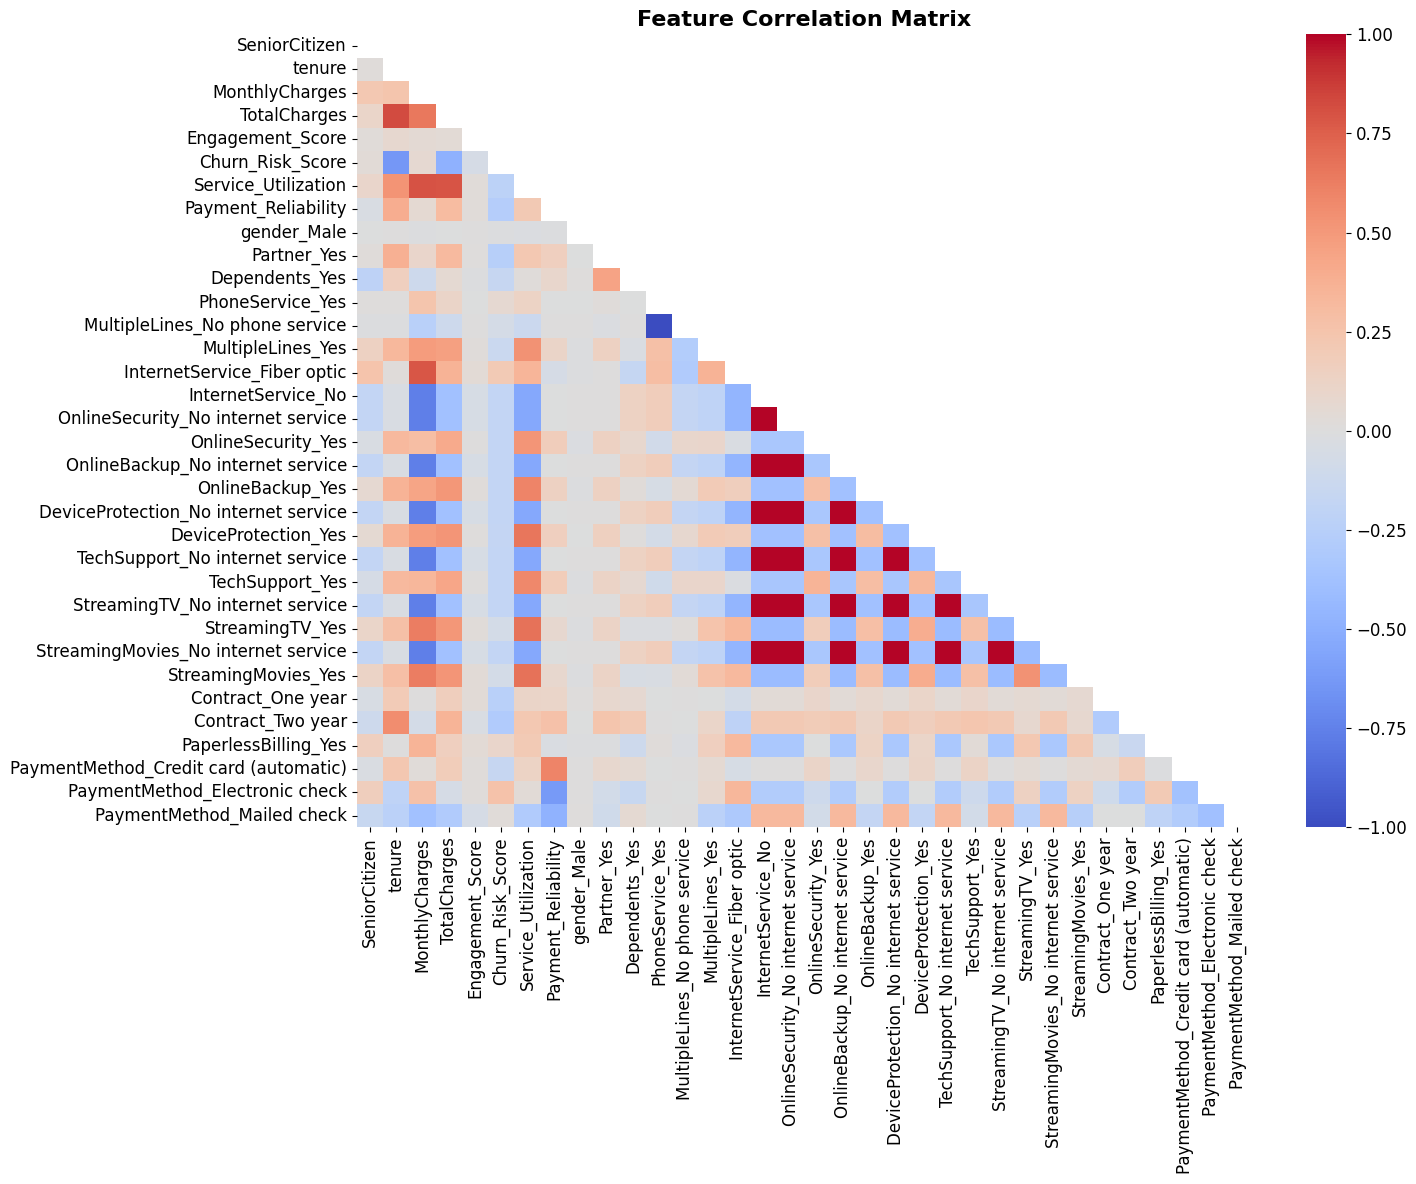

In [6]:

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# Save a copy of the dataset before feature engineering for comparative analysis
df_no_fe = df.copy()
print("✓ Saved dataset copy without feature engineering")

# Check if required columns exist before feature engineering
required_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"⚠ Missing required columns for feature engineering: {missing_cols}")
    print("Skipping advanced feature engineering...")
else:
    # New feature: Engagement Score
    df['Engagement_Score'] = df['tenure'] * df['MonthlyCharges'] / (df['TotalCharges'] + 1)
    print("✓ Added Engagement_Score feature")

    # New feature: Churn Risk Score
    df['Churn_Risk_Score'] = df['tenure'].apply(lambda x: 1 if x < 12 else 0) * df['MonthlyCharges']
    print("✓ Added Churn_Risk_Score feature")

# Service utilization (if service columns exist)
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
existing_service_cols = [col for col in service_cols if col in df.columns]
if existing_service_cols:
    df['Service_Utilization'] = df[existing_service_cols].eq('Yes').sum(axis=1)
    print("✓ Added Service_Utilization feature")

# Payment reliability (if payment method column exists)
if 'PaymentMethod' in df.columns:
    df['Payment_Reliability'] = df['PaymentMethod'].apply(
        lambda x: 1 if x in ['Bank transfer (automatic)', 'Credit card (automatic)'] else 0
    )
    print("✓ Added Payment_Reliability feature")

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
if categorical_features:
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    print(f"✓ One-hot encoding completed")
else:
    df_encoded = df.copy()
    print("✓ No categorical features to encode")

print(f"Features after encoding: {df_encoded.shape[1] - 1}")


#### TAMBAHAN: Prepare dataset without feature engineering
categorical_features_no_fe = df_no_fe.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features_no_fe:
    categorical_features_no_fe.remove('Churn')

if categorical_features_no_fe:
    df_encoded_no_fe = pd.get_dummies(df_no_fe, columns=categorical_features_no_fe, drop_first=True)
    print(f"✓ One-hot encoding completed for dataset without feature engineering")
else:
    df_encoded_no_fe = df_no_fe.copy()
    print("✓ No categorical features to encode for dataset without feature engineering")

# TAMBAHAN: Prepare features and target for no feature engineering
X_no_fe = df_encoded_no_fe.drop("Churn", axis=1)
y_no_fe = (df_encoded_no_fe["Churn"] == "Yes").astype(int)
print(f"Final feature matrix shape (without FE): {X_no_fe.shape}")
####

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)
print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis (only if we have multiple features)
if X.shape[1] > 1:
    plt.figure(figsize=(15, 12))
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()


In [7]:

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Compare imbalance handling methods
imbalance_methods = {
    'SMOTE': SMOTE(random_state=RANDOM_SEED),
    'SMOTEENN': SMOTEENN(random_state=RANDOM_SEED),
    'RandomUnderSampler': RandomUnderSampler(random_state=RANDOM_SEED),
    'ADASYN': ADASYN(random_state=RANDOM_SEED)
}

imbalance_results = {}
for name, sampler in imbalance_methods.items():
    try:
        print(f"Applying {name}...")
        X_res, y_res = sampler.fit_resample(X_scaled, y)
        X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
            X_res, y_res, stratify=y_res, test_size=0.25, random_state=RANDOM_SEED
        )
        imbalance_results[name] = {'shape': X_res.shape, 'target_dist': np.bincount(y_res)}
        print(f"✓ {name} - Resampled shape: {X_res.shape}, Target distribution: {np.bincount(y_res)}")
    except Exception as e:
        print(f"⚠ {name} failed: {str(e)}")
        continue

# Use SMOTE for main analysis
try:
    smote = SMOTE(random_state=RANDOM_SEED)
    X_scaled_res, y_res = smote.fit_resample(X_scaled, y)
    print(f"✓ SMOTE applied - Resampled dataset shape: {X_scaled_res.shape}")
    print(f"Resampled target distribution: {np.bincount(y_res)}")
except Exception as e:
    print(f"⚠ SMOTE failed, using original data: {str(e)}")
    X_scaled_res, y_res = X_scaled, y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_res, y_res, stratify=y_res, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# TAMBAHAN: Feature scaling for dataset without feature engineering
X_scaled_no_fe = scaler.fit_transform(X_no_fe)
print("✓ Feature scaling completed for dataset without feature engineering")

# TAMBAHAN: Train-test split for no feature engineering
X_train_no_fe, X_test_no_fe, y_train_no_fe, y_test_no_fe = train_test_split(
    X_scaled_no_fe, y_no_fe, stratify=y_no_fe, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape (No FE): {X_train_no_fe.shape}")
print(f"Testing set shape (No FE): {X_test_no_fe.shape}")

# TAMBAHAN: Train-test split for feature engineering without SMOTE
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_scaled, y, stratify=y, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape (FE only): {X_train_fe.shape}")
print(f"Testing set shape (FE only): {X_test_fe.shape}")


STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
Applying SMOTE...
✓ SMOTE - Resampled shape: (10348, 34), Target distribution: [5174 5174]
Applying SMOTEENN...
✓ SMOTEENN - Resampled shape: (6559, 34), Target distribution: [2801 3758]
Applying RandomUnderSampler...
✓ RandomUnderSampler - Resampled shape: (3738, 34), Target distribution: [1869 1869]
Applying ADASYN...
✓ ADASYN - Resampled shape: (10343, 34), Target distribution: [5174 5169]
✓ SMOTE applied - Resampled dataset shape: (10348, 34)
Resampled target distribution: [5174 5174]
Training set shape: (7761, 34)
Testing set shape: (2587, 34)
Training set class distribution: [3880 3881]
Testing set class distribution: [1294 1293]
✓ Feature scaling completed for dataset without feature engineering
Training set shape (No FE): (5282, 30)
Testing set shape (No FE): (1761, 30)
Training set shape (FE only): (5282, 34)
Testing set shape (FE only): (1761, 34)



Target Distribution After SMOTE:
Churn  Count  Percentage
   No   5174        50.0
  Yes   5174        50.0
✓ Resampled target distribution saved to CSV


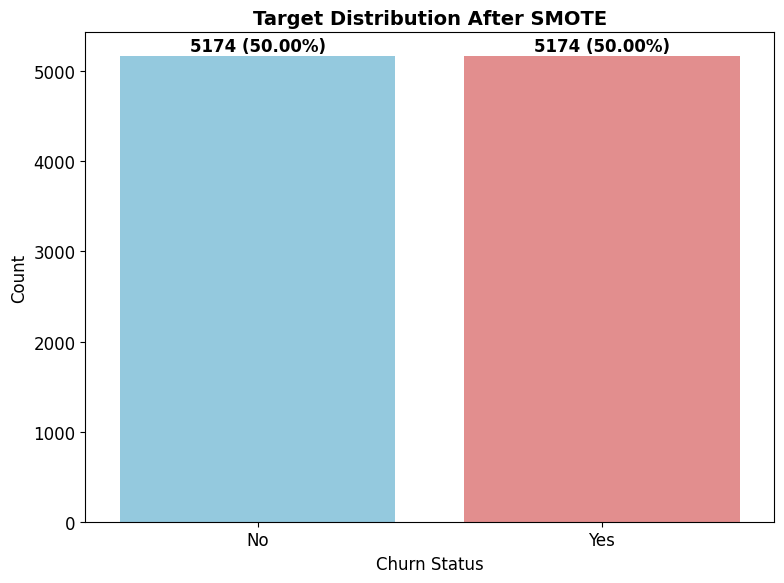

In [24]:
# === STEP 4.3: Create and visualize target distribution after SMOTE ===
print("\nTarget Distribution After SMOTE:")
target_dist_resampled = pd.Series(y_res).value_counts()
target_dist_df = pd.DataFrame({
    'Churn': ['No', 'Yes'],
    'Count': [target_dist_resampled.get(0, 0), target_dist_resampled.get(1, 0)],
    'Percentage': [target_dist_resampled.get(0, 0) / len(y_res) * 100, target_dist_resampled.get(1, 0) / len(y_res) * 100]
})
print(target_dist_df.to_string(index=False))

# Save resampled target distribution to CSV
target_dist_df.to_csv(f"{OUTPUT_DIR}/data/resampled_target_distribution.csv", index=False)
print("✓ Resampled target distribution saved to CSV")

# Visualize resampled target distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='Churn', y='Count', data=target_dist_df, palette=['skyblue', 'lightcoral'])
plt.title('Target Distribution After SMOTE', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
for i, v in enumerate(target_dist_df['Count']):
    plt.text(i, v + 50, f"{v} ({target_dist_df['Percentage'][i]:.2f}%)", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/resampled_target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# === STEP 4.5: COMPARATIVE MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 4.5: COMPARATIVE MODEL EVALUATION")
print("="*50)

# Define function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test, scenario_name):
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            'Scenario': scenario_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba)
        }

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Churn', 'Churn'],
                    yticklabels=['No Churn', 'Churn'])
        plt.title(f'Confusion Matrix - {scenario_name}', fontweight='bold')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix_{scenario_name.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
        plt.show()

        return metrics
    except Exception as e:
        print(f"⚠ Error evaluating {scenario_name}: {str(e)}")
        return None

# Placeholder for best model (to be determined after tuning)
comparative_results = []

# Define scenarios
scenarios = [
    ('No Feature Engineering', X_train_no_fe, y_train_no_fe, X_test_no_fe, y_test_no_fe),
    ('Feature Engineering', X_train_fe, y_train_fe, X_test_fe, y_test_fe),
    ('Feature Engineering + SMOTE', X_train, y_train, X_test, y_test)
]

# Note: Actual evaluation will be done after selecting the best model in Step 5
print("✓ Scenarios defined for comparative evaluation")


STEP 4.5: COMPARATIVE MODEL EVALUATION
✓ Scenarios defined for comparative evaluation



STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing Bayesian hyperparameter tuning...
Tuning DecisionTree...
✓ DecisionTree best score: 0.8619
Tuning GBM...
✓ GBM best score: 0.9322
Tuning XGBoost...
✓ XGBoost best score: 0.9351
Tuning RandomForest...
✓ RandomForest best score: 0.9231
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8553
Tuning SVC...
✓ SVC best score: 0.8871
Tuning NeuralNet...
✓ NeuralNet best score: 0.8729
Tuning AdaBoost...
✓ AdaBoost best score: 0.9164
Tuning LightGBM...
✓ LightGBM best score: 0.9335
Tuning CatBoost...
✓ CatBoost best score: 0.9361
✓ Hyperparameter tuning results saved
Selected best model for comparative evaluation: CatBoost
Evaluating best model on different scenarios...


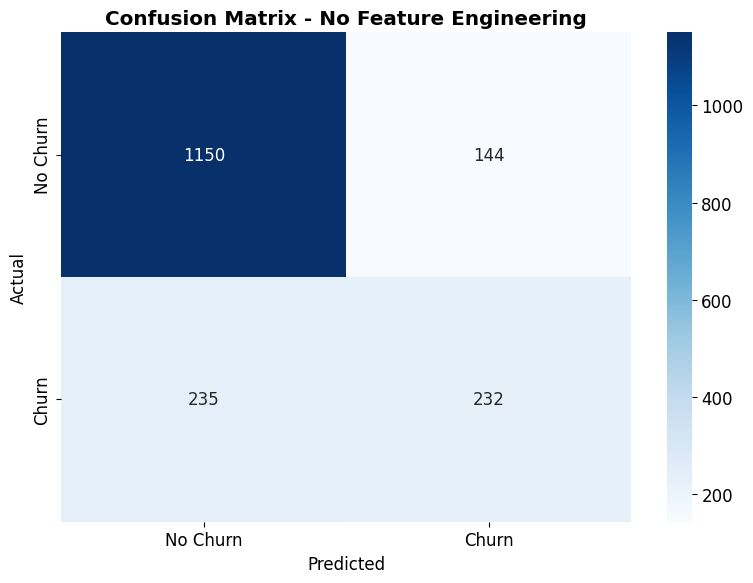

✓ No Feature Engineering evaluation completed
Metrics: {'Scenario': 'No Feature Engineering', 'Accuracy': 0.7847813742191937, 'Precision': 0.6170212765957447, 'Recall': 0.49678800856531047, 'F1': 0.5504151838671412, 'ROC_AUC': 0.8248811017080976}


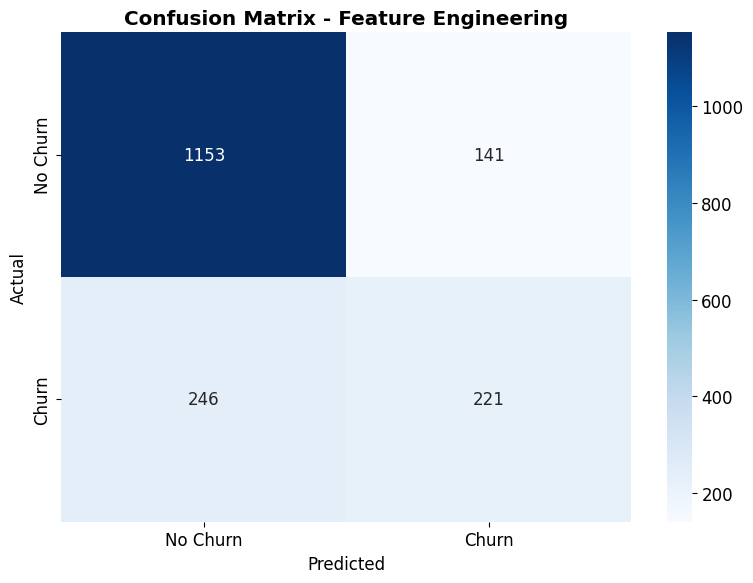

✓ Feature Engineering evaluation completed
Metrics: {'Scenario': 'Feature Engineering', 'Accuracy': 0.7802385008517888, 'Precision': 0.6104972375690608, 'Recall': 0.4732334047109208, 'F1': 0.5331724969843185, 'ROC_AUC': 0.8239866754482059}


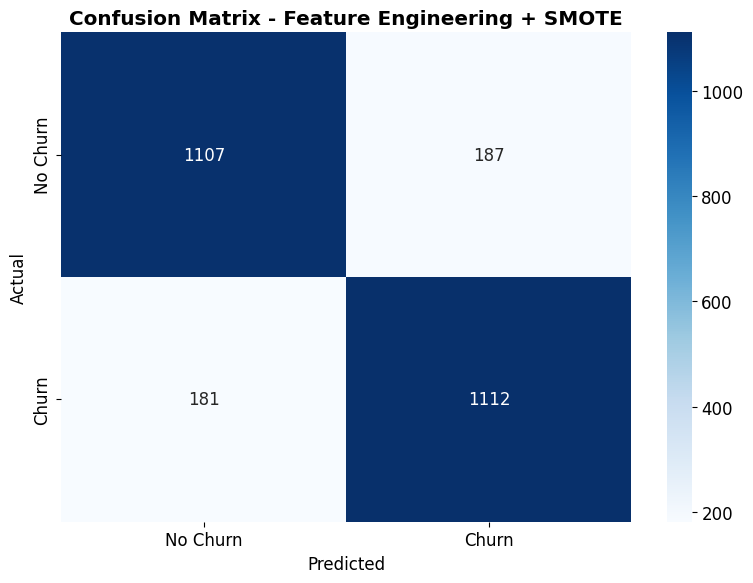

✓ Feature Engineering + SMOTE evaluation completed
Metrics: {'Scenario': 'Feature Engineering + SMOTE', 'Accuracy': 0.8577502899110939, 'Precision': 0.8560431100846805, 'Recall': 0.860015467904099, 'F1': 0.8580246913580247, 'ROC_AUC': 0.938701855550814}
✓ Comparative model results saved


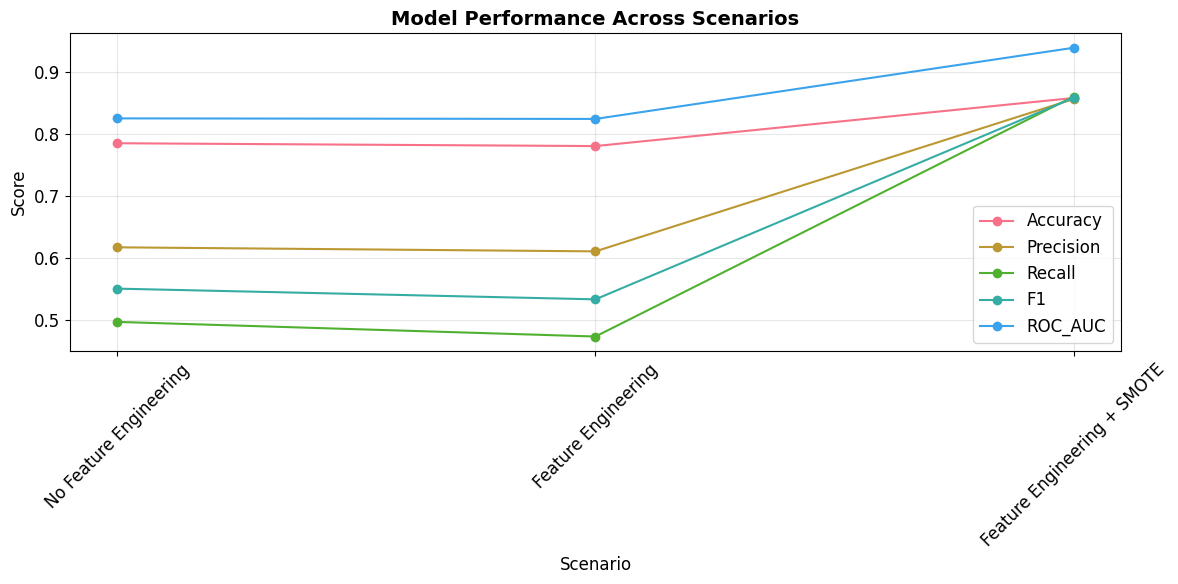

In [9]:

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with expanded hyperparameter grids
models_config = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=RANDOM_SEED),
        "params": {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
    },
    "GBM": {
        "model": GradientBoostingClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED, verbosity=0),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        "params": {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    "SVC": {
        "model": SVC(probability=True, random_state=RANDOM_SEED),
        "params": {'C': [0.1, 1], 'kernel': ['rbf', 'linear']}
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=200, random_state=RANDOM_SEED, early_stopping=True),
        "params": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001]}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=RANDOM_SEED, verbosity=-1),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "CatBoost": {
        "model": CatBoostClassifier(random_state=RANDOM_SEED, verbose=0),
        "params": {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5]}
    }
}

# Bayesian optimization for hyperparameter tuning
tuned_models = {}
tuning_results = []

def objective(trial, model_name, X_train, y_train):
    params = {}
    try:
        if model_name == "XGBoost":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0)
            }
            model = XGBClassifier(**params, random_state=RANDOM_SEED, eval_metric='logloss', verbosity=0)
        elif model_name == "LightGBM":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10)
            }
            model = LGBMClassifier(**params, random_state=RANDOM_SEED, verbosity=-1)
        elif model_name == "CatBoost":
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 3, 10)
            }
            model = CatBoostClassifier(**params, random_state=RANDOM_SEED, verbose=0)
        else:
            model = models_config[model_name]["model"]
            params = {key: trial.suggest_categorical(key, values)
                     for key, values in models_config[model_name]["params"].items()}
            model.set_params(**params)

        score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return score
    except Exception as e:
        print(f"Error in objective for {model_name}: {str(e)}")
        return 0.5  # Return neutral score on error

print("Performing Bayesian hyperparameter tuning...")
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reduce optuna output

for name in models_config.keys():
    print(f"Tuning {name}...")
    try:
        study = optuna.create_study(direction='maximize')
       # Timeout + trial untuk semua model (light tuning)
        if name in ["DecisionTree", "LogisticRegression"]:
            study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=10, timeout=120)
        elif name in ["GBM", "RandomForest", "AdaBoost"]:
            study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=10, timeout=240)
        elif name in ["XGBoost", "LightGBM", "CatBoost", "SVC", "NeuralNet"]:
            study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=15, timeout=360)

        best_params = study.best_params
        model = models_config[name]["model"]
        model.set_params(**best_params)
        tuned_models[name] = model
        print(f"✓ {name} best score: {study.best_value:.4f}")
        tuning_results.append({'Model': name, 'Best_Score': study.best_value, 'Best_Params': best_params})
    except Exception as e:
        print(f"⚠ Error tuning {name}: {str(e)}")
        # Use default model if tuning fails
        tuned_models[name] = models_config[name]["model"]
        tuning_results.append({'Model': name, 'Best_Score': 0.5, 'Best_Params': {}})

# Save tuning results
tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_csv(f"{OUTPUT_DIR}/data/hyperparameter_tuning_results.csv", index=False)
print("✓ Hyperparameter tuning results saved")

# TAMBAHAN: Select best model for comparative evaluation
best_model_name = max(tuned_models, key=lambda k: tuning_df[tuning_df['Model'] == k]['Best_Score'].iloc[0])
best_model = tuned_models[best_model_name]
print(f"Selected best model for comparative evaluation: {best_model_name}")

# TAMBAHAN: Evaluate best model on all scenarios
print("Evaluating best model on different scenarios...")
comparative_results = []  # Inisialisasi di sini agar tersedia untuk Langkah 13

# Define scenarios (assuming these variables are defined in Step 4)
scenarios = [
    ('No Feature Engineering', X_train_no_fe, y_train_no_fe, X_test_no_fe, y_test_no_fe),
    ('Feature Engineering', X_train_fe, y_train_fe, X_test_fe, y_test_fe),
    ('Feature Engineering + SMOTE', X_train, y_train, X_test, y_test)
]

for scenario_name, X_tr, y_tr, X_te, y_te in scenarios:
    try:
        best_model.fit(X_tr, y_tr)
        y_pred = best_model.predict(X_te)
        y_pred_proba = best_model.predict_proba(X_te)[:, 1]

        metrics = {
            'Scenario': scenario_name,
            'Accuracy': accuracy_score(y_te, y_pred),
            'Precision': precision_score(y_te, y_pred, zero_division=0),
            'Recall': recall_score(y_te, y_pred, zero_division=0),
            'F1': f1_score(y_te, y_pred, zero_division=0),
            'ROC_AUC': roc_auc_score(y_te, y_pred_proba)
        }

        # Confusion Matrix
        cm = confusion_matrix(y_te, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Churn', 'Churn'],
                    yticklabels=['No Churn', 'Churn'])
        plt.title(f'Confusion Matrix - {scenario_name}', fontweight='bold')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix_{scenario_name.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
        plt.show()

        comparative_results.append(metrics)
        print(f"✓ {scenario_name} evaluation completed")
        print(f"Metrics: {metrics}")
    except Exception as e:
        print(f"⚠ Error evaluating {scenario_name}: {str(e)}")

# TAMBAHAN: Save comparative results
comparative_results_df = pd.DataFrame(comparative_results)
comparative_results_df.to_csv(f"{OUTPUT_DIR}/data/comparative_model_results.csv", index=False)
print("✓ Comparative model results saved")

# TAMBAHAN: Visualize comparative results
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
for metric in metrics_to_plot:
    plt.plot(comparative_results_df['Scenario'], comparative_results_df[metric], marker='o', label=metric)
plt.title('Model Performance Across Scenarios', fontsize=14, fontweight='bold')
plt.xlabel('Scenario')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/comparative_model_performance.png", dpi=300, bbox_inches='tight')
plt.show()


STEP 6: CROSS-VALIDATION EVALUATION
Performing 5-fold cross-validation...
--------------------------------------------------------------------------------
Model           ROC-AUC      Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
DecisionTree    0.8680±0.005 0.7948±0.006 0.7669±0.014 0.8483±0.017 0.8052±0.005
GBM             0.9365±0.006 0.8551±0.008 0.8507±0.006 0.8616±0.018 0.8560±0.009
XGBoost         0.9390±0.004 0.8583±0.007 0.8533±0.005 0.8655±0.015 0.8593±0.008
RandomForest    0.9316±0.004 0.8606±0.005 0.8502±0.008 0.8757±0.010 0.8627±0.006
LogisticRegression 0.8579±0.008 0.7763±0.010 0.7555±0.008 0.8170±0.013 0.7850±0.010
SVC             0.8951±0.007 0.8086±0.007 0.7898±0.006 0.8409±0.008 0.8146±0.007
NeuralNet       0.8830±0.009 0.8073±0.013 0.7872±0.014 0.8427±0.025 0.8138±0.014
AdaBoost        0.9179±0.006 0.8323±0.010 0.8085±0.010 0.8711±0.015 0.8386±0.010
LightGBM        0.9358±0.005 0.8537±0.0

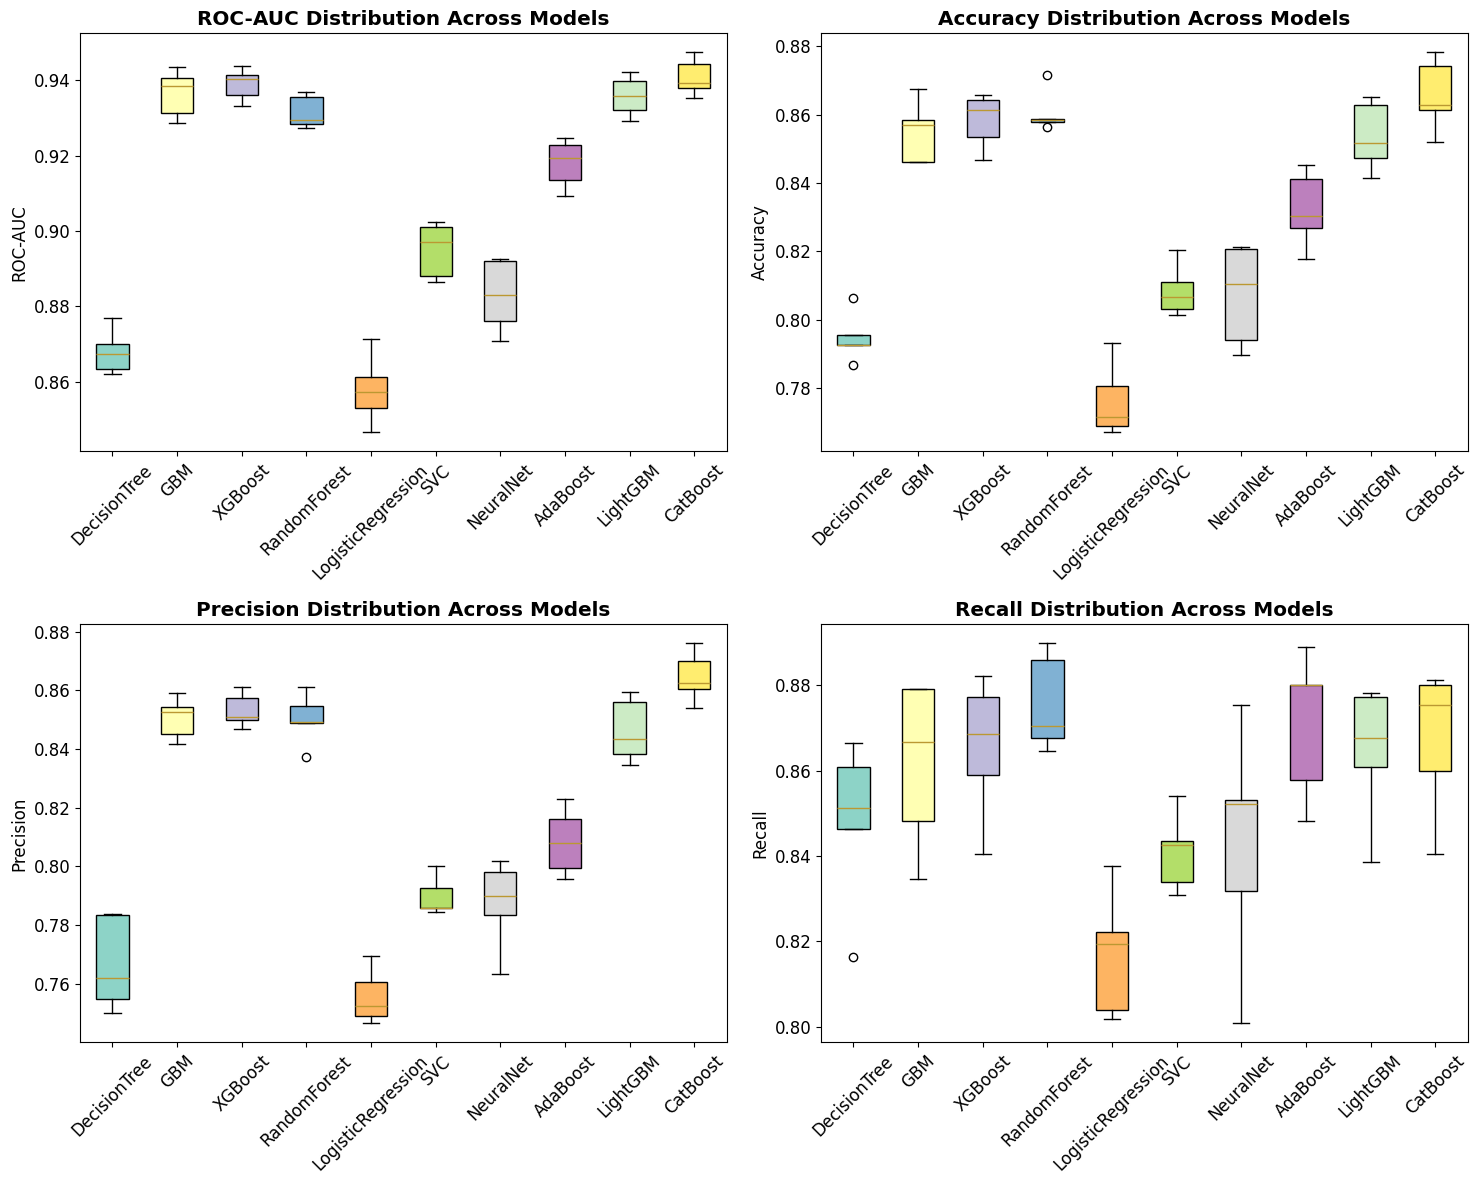

In [10]:
# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)  # Reduced from 10 to 5
cv_results = {}
metrics_results = {}
cv_metrics_per_fold = {}

print("Performing 5-fold cross-validation...")
print("-" * 80)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for name, model in tuned_models.items():
    try:
        cv_metrics_per_fold[name] = {'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

        for train_idx, val_idx in cv.split(X_scaled_res, y_res):
            X_cv_train, X_cv_val = X_scaled_res[train_idx], X_scaled_res[val_idx]
            y_cv_train, y_cv_val = y_res[train_idx], y_res[val_idx]

            model.fit(X_cv_train, y_cv_train)
            y_pred = model.predict(X_cv_val)
            y_pred_proba = model.predict_proba(X_cv_val)[:, 1]

            cv_metrics_per_fold[name]['roc_auc'].append(roc_auc_score(y_cv_val, y_pred_proba))
            cv_metrics_per_fold[name]['accuracy'].append(accuracy_score(y_cv_val, y_pred))
            cv_metrics_per_fold[name]['precision'].append(precision_score(y_cv_val, y_pred, zero_division=0))
            cv_metrics_per_fold[name]['recall'].append(recall_score(y_cv_val, y_pred, zero_division=0))
            cv_metrics_per_fold[name]['f1'].append(f1_score(y_cv_val, y_pred, zero_division=0))

        roc_scores = np.array(cv_metrics_per_fold[name]['roc_auc'])
        acc_scores = np.array(cv_metrics_per_fold[name]['accuracy'])
        prec_scores = np.array(cv_metrics_per_fold[name]['precision'])
        rec_scores = np.array(cv_metrics_per_fold[name]['recall'])
        f1_scores = np.array(cv_metrics_per_fold[name]['f1'])

        cv_results[name] = roc_scores
        metrics_results[name] = {
            'roc_auc': roc_scores,
            'accuracy': acc_scores,
            'precision': prec_scores,
            'recall': rec_scores,
            'f1': f1_scores
        }

        print(f"{name:<15} {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
              f"{acc_scores.mean():.4f}±{acc_scores.std():.3f} "
              f"{prec_scores.mean():.4f}±{prec_scores.std():.3f} "
              f"{rec_scores.mean():.4f}±{rec_scores.std():.3f} "
              f"{f1_scores.mean():.4f}±{f1_scores.std():.3f}")
    except Exception as e:
        print(f"⚠ Error evaluating {name}: {str(e)}")
        continue

# Save per-fold metrics
if cv_metrics_per_fold:
    cv_metrics_df = pd.DataFrame({
        'Model': [name for name in cv_metrics_per_fold for _ in range(5)],
        'Fold': list(range(1, 6)) * len(cv_metrics_per_fold),
        'ROC_AUC': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['roc_auc']],
        'Accuracy': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['accuracy']],
        'Precision': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['precision']],
        'Recall': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['recall']],
        'F1': [score for name in cv_metrics_per_fold for score in cv_metrics_per_fold[name]['f1']]
    })
    cv_metrics_df.to_csv(f"{OUTPUT_DIR}/data/cv_metrics_per_fold.csv", index=False)
    print("✓ Cross-validation metrics per fold saved")

# Create performance comparison plot
if metrics_results:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
    titles = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx//2, idx%2]
        data = [metrics_results[model][metric] for model in tuned_models.keys() if model in metrics_results]
        labels = [model for model in tuned_models.keys() if model in metrics_results]

        if data:
            bp = ax.boxplot(data, labels=labels, patch_artist=True)
            ax.set_title(f'{title} Distribution Across Models', fontweight='bold')
            ax.set_ylabel(title)
            ax.tick_params(axis='x', rotation=45)
            colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

In [11]:

# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

if cv_results:
    # Wilcoxon signed-rank test
    print("Wilcoxon Signed-Rank Test Results:")
    print("-" * 50)
    best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
    print(f"Best performing model (baseline): {best_model}")
    print(f"Baseline ROC-AUC: {cv_results[best_model].mean():.4f} ± {cv_results[best_model].std():.4f}")
    print()

    baseline_scores = cv_results[best_model]
    significance_results = {}
    for name, scores in cv_results.items():
        if name != best_model:
            try:
                stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
                significance_results[name] = p_value
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                print(f"{name:<15} vs {best_model}: p-value = {p_value:.6f} {significance}")
            except Exception as e:
                print(f"⚠ Error in Wilcoxon test for {name}: {str(e)}")
                significance_results[name] = 1.0

    # Friedman test
    print(f"\nFriedman Test (Multiple Model Comparison):")
    try:
        all_scores = [scores for scores in cv_results.values()]
        friedman_stat, friedman_p = friedmanchisquare(*all_scores)
        print(f"Friedman statistic: {friedman_stat:.4f}")
        print(f"p-value: {friedman_p:.6f}")
    except Exception as e:
        print(f"⚠ Error in Friedman test: {str(e)}")
else:
    print("No cross-validation results available for statistical testing")
    best_model = list(tuned_models.keys())[0]  # Use first model as default
    significance_results = {}



STEP 7: STATISTICAL SIGNIFICANCE TESTING
Wilcoxon Signed-Rank Test Results:
--------------------------------------------------
Best performing model (baseline): CatBoost
Baseline ROC-AUC: 0.9408 ± 0.0044

DecisionTree    vs CatBoost: p-value = 0.062500 ns
GBM             vs CatBoost: p-value = 0.062500 ns
XGBoost         vs CatBoost: p-value = 0.125000 ns
RandomForest    vs CatBoost: p-value = 0.062500 ns
LogisticRegression vs CatBoost: p-value = 0.062500 ns
SVC             vs CatBoost: p-value = 0.062500 ns
NeuralNet       vs CatBoost: p-value = 0.062500 ns
AdaBoost        vs CatBoost: p-value = 0.062500 ns
LightGBM        vs CatBoost: p-value = 0.062500 ns

Friedman Test (Multiple Model Comparison):
Friedman statistic: 44.5636
p-value: 0.000001



STEP 8: FINAL MODEL EVALUATION
Final Model Performance (CatBoost):
----------------------------------------
ACCURACY  : 0.8578
PRECISION : 0.8560
RECALL    : 0.8600
F1        : 0.8580
ROC_AUC   : 0.9387

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1294
           1       0.86      0.86      0.86      1293

    accuracy                           0.86      2587
   macro avg       0.86      0.86      0.86      2587
weighted avg       0.86      0.86      0.86      2587



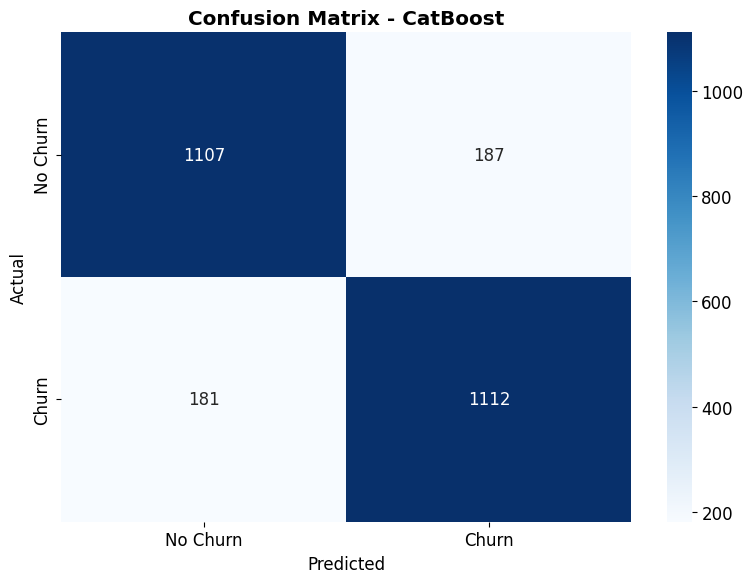

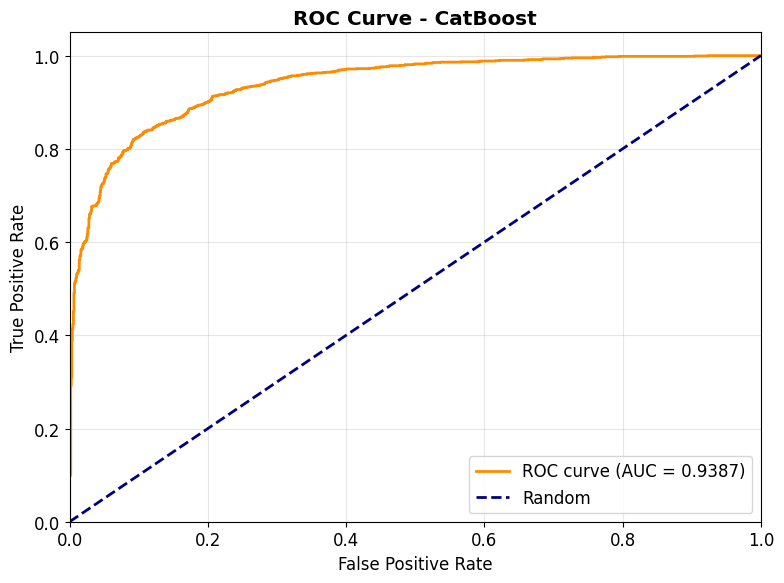

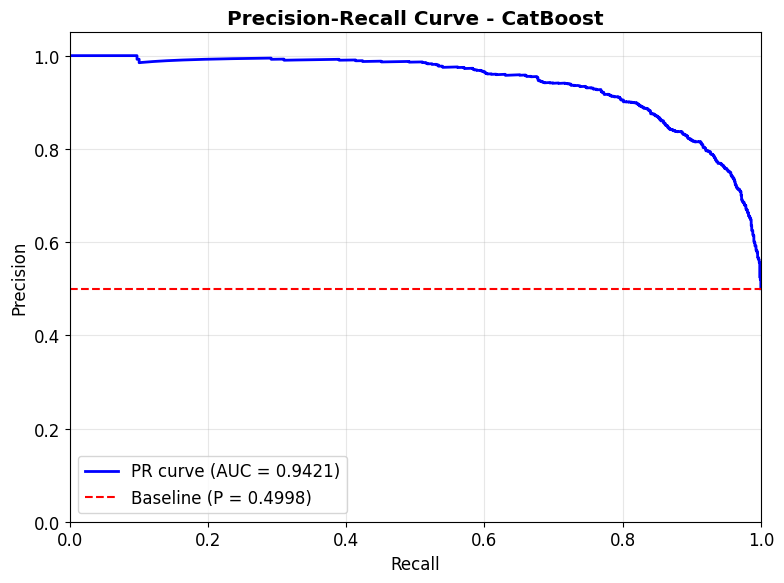

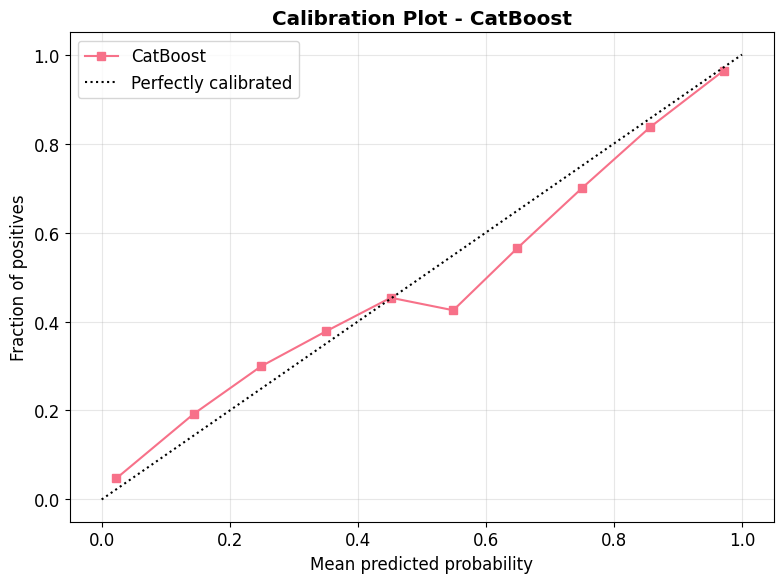

✓ Final model saved


In [12]:
# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION")
print("="*50)

# Train the best model
final_model = tuned_models[best_model]
# Convert to DataFrame if needed
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=X.columns)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X.columns)


# final_model.fit(X_train, y_train)
# FIX INI DULU
feature_names = X.columns
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Baru model training kayak biasa
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)


# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
# Lanjutan dari kode sebelumnya - mulai dari ROC Curve yang terpotong
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline (P = {y_test.mean():.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'{best_model}')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.xlabel('Mean predicted probability')
plt.title(f'Calibration Plot - {best_model}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/calibration_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Save final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")
print("✓ Final model saved")


STEP 9: FEATURE IMPORTANCE ANALYSIS
X_test_df columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Engagement_Score', 'Churn_Risk_Score', 'Service_Utilization', 'Payment_Reliability', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
X_test_df shape: (2587, 34)
Model used: CatBoostClassifier
Top 10 Most Important Features:
--------

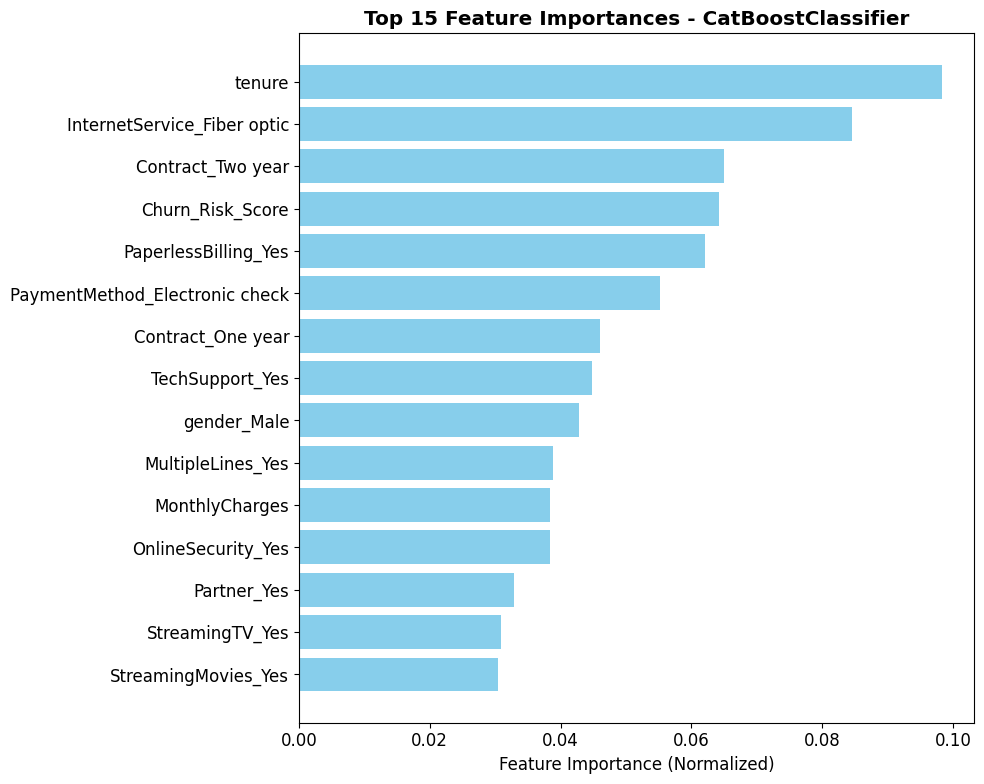

✓ Feature importance saved


In [13]:
# === STEP 9: FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Prepare X_test_df for consistency
X_test_df = pd.DataFrame(X_test, columns=X.columns)
print("X_test_df columns:", X_test_df.columns.tolist())
print("X_test_df shape:", X_test_df.shape)
print(f"Model used: {type(final_model).__name__}")

try:
    # Use SHAP for feature importance
    import shap
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_df)
    shap_importance = np.abs(shap_values).mean(axis=0)
    total_importance = shap_importance.sum()
    importance_df = pd.DataFrame({
        'feature': X_test_df.columns,
        'importance': shap_importance / total_importance  # Normalized importance
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    print("-" * 40)
    print(importance_df.head(10).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Normalized)')
    plt.title(f'Top 15 Feature Importances - {type(final_model).__name__}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Save feature importance
    importance_df.to_csv(f"{OUTPUT_DIR}/data/feature_importance.csv", index=False)
    print("✓ Feature importance saved")
except Exception as e:
    print(f"⚠ Feature importance analysis failed: {str(e)}")
    print("Continuing without feature importance...")
    importance_df = pd.DataFrame()

In [14]:
print("Total importance:", importance_df['importance'].sum())

Total importance: 1.0



STEP 10: SHAP ANALYSIS
Generating SHAP explanations...
X_test_df shape: (2587, 34)
Model used: CatBoostClassifier


100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


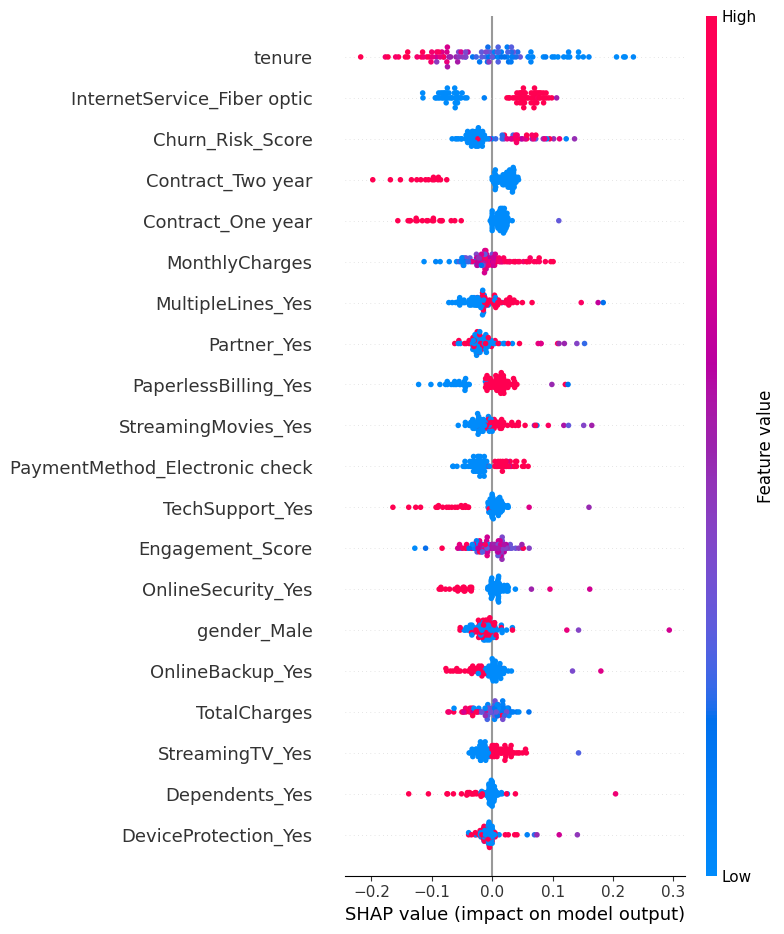

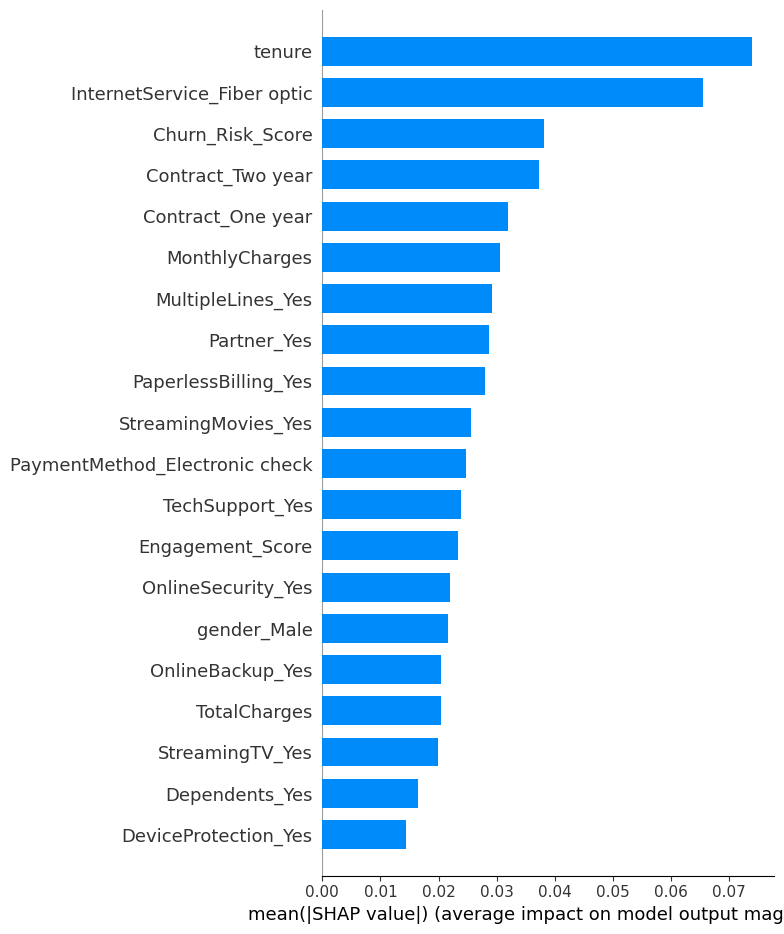

✓ SHAP analysis completed


In [15]:
 # === STEP 10: SHAP ANALYSIS ===
print("\n" + "="*50)
print("STEP 10: SHAP ANALYSIS")
print("="*50)
try:
    print("Generating SHAP explanations...")
    if not isinstance(X_test, pd.DataFrame):
        X_test_df = pd.DataFrame(X_test, columns=X.columns)
    else:
        X_test_df = X_test

    print("X_test_df shape:", X_test_df.shape)
    print("Model used:", type(final_model).__name__)

    # Prepare training data for KernelExplainer (if needed)
    if not 'X_train' in globals():
        print("⚠ X_train not found, using X_test_df[:100] as fallback for KernelExplainer.")
        X_train_df = X_test_df[:100].copy()
    else:
        if not isinstance(X_train, pd.DataFrame):
            X_train_df = pd.DataFrame(X_train, columns=X.columns)
        else:
            X_train_df = X_train

    if best_model.__class__.__name__ in ['LGBMClassifier', 'XGBClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'CatBoostClassifier']:
        explainer = shap.TreeExplainer(final_model, feature_names=X.columns.tolist())
        shap_values = explainer.shap_values(X_test_df[:500], check_additivity=False)
        shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
    else:
        explainer = shap.KernelExplainer(
            lambda x: final_model.predict_proba(x)[:, 1],
            X_train_df[:100],
            feature_names=X.columns.tolist()
        )
        shap_values = explainer.shap_values(X_test_df[:100])
        shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_test_df[:len(shap_values_plot)],
                     feature_names=X.columns.tolist(), show=False)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_plot, X_test_df[:len(shap_values_plot)],
                     feature_names=X.columns.tolist(), plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_bar.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ SHAP analysis completed")

except Exception as e:
    print(f"⚠ SHAP analysis failed: {str(e)}")
    print("Continuing without SHAP analysis...")

In [16]:
print("X_test_df dtypes:", X_test_df.dtypes)

X_test_df dtypes: SeniorCitizen                            float64
tenure                                   float64
MonthlyCharges                           float64
TotalCharges                             float64
Engagement_Score                         float64
Churn_Risk_Score                         float64
Service_Utilization                      float64
Payment_Reliability                      float64
gender_Male                              float64
Partner_Yes                              float64
Dependents_Yes                           float64
PhoneService_Yes                         float64
MultipleLines_No phone service           float64
MultipleLines_Yes                        float64
InternetService_Fiber optic              float64
InternetService_No                       float64
OnlineSecurity_No internet service       float64
OnlineSecurity_Yes                       float64
OnlineBackup_No internet service         float64
OnlineBackup_Yes                         float64
De

In [17]:

# === STEP 11: BIAS AND FAIRNESS ANALYSIS ===
print("\n" + "="*50)
print("STEP 11: BIAS AND FAIRNESS ANALYSIS")
print("="*50)
try:
    # Check if we have demographic features for fairness analysis
    demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
    available_demo_features = [f for f in demographic_features if f in df.columns or
                              any(col.startswith(f) for col in df.columns)]

    if available_demo_features:
        print(f"Available demographic features: {available_demo_features}")

        # Create fairness analysis for SeniorCitizen if available
        if 'SeniorCitizen' in df.columns:
            # Get original test data (before resampling)
            X_test_orig, y_test_orig = X_scaled, y  # Use original data
            X_test_orig_df = pd.DataFrame(X_test_orig, columns=X.columns, index=df.index)
            y_test_orig_series = pd.Series(y_test_orig, index=df.index)
            y_pred_orig = final_model.predict(X_test_orig_df)

            # Create demographic parity analysis
            senior_mask = df['SeniorCitizen'] == 1

            # Calculate fairness metrics
            senior_pred_rate = y_pred_orig[senior_mask].mean()
            non_senior_pred_rate = y_pred_orig[~senior_mask].mean()
            demographic_parity = abs(senior_pred_rate - non_senior_pred_rate)

            print(f"Demographic Parity Analysis:")
            print(f"- Senior citizens positive prediction rate: {senior_pred_rate:.4f}")
            print(f"- Non-senior citizens positive prediction rate: {non_senior_pred_rate:.4f}")
            print(f"- Demographic parity difference: {demographic_parity:.4f}")

            # Equal opportunity analysis
            senior_tpr = recall_score(y_test_orig_series[senior_mask], y_pred_orig[senior_mask], zero_division=0)
            non_senior_tpr = recall_score(y_test_orig_series[~senior_mask], y_pred_orig[~senior_mask], zero_division=0)
            equalized_odds = abs(senior_tpr - non_senior_tpr)

            print(f"Equal Opportunity Analysis:")
            print(f"- Senior citizens TPR: {senior_tpr:.4f}")
            print(f"- Non-senior citizens TPR: {non_senior_tpr:.4f}")
            print(f"- Equalized odds difference: {equalized_odds:.4f}")

        else:
            print("⚠ SeniorCitizen column not found for fairness analysis")
    else:
        print("⚠ No demographic features found for fairness analysis")

except Exception as e:
    print(f"⚠ Fairness analysis failed: {str(e)}")


STEP 11: BIAS AND FAIRNESS ANALYSIS
Available demographic features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
Demographic Parity Analysis:
- Senior citizens positive prediction rate: 0.4588
- Non-senior citizens positive prediction rate: 0.2418
- Demographic parity difference: 0.2170
Equal Opportunity Analysis:
- Senior citizens TPR: 0.9559
- Non-senior citizens TPR: 0.8887
- Equalized odds difference: 0.0672



STEP 12: COUNTERFACTUAL EXPLANATIONS
Generating counterfactual explanations...


100%|██████████| 3/3 [00:48<00:00, 16.23s/it]



✓ Counterfactual explanations generated

Original instance (scaled):
SeniorCitizen                           -0.487793
tenure                                  -0.438308
MonthlyCharges                          -1.712891
TotalCharges                            -0.771451
Engagement_Score                        -0.853308
Churn_Risk_Score                        -0.694180
Service_Utilization                     -1.168283
Payment_Reliability                      1.300168
gender_Male                              1.022980
Partner_Yes                             -0.885573
Dependents_Yes                          -0.588939
PhoneService_Yes                         0.291026
MultipleLines_No phone service          -0.291026
MultipleLines_Yes                       -0.885204
InternetService_Fiber optic             -1.079808
InternetService_No                       2.265024
OnlineSecurity_No internet service       2.265024
OnlineSecurity_Yes                      -0.558186
OnlineBackup_No internet servi

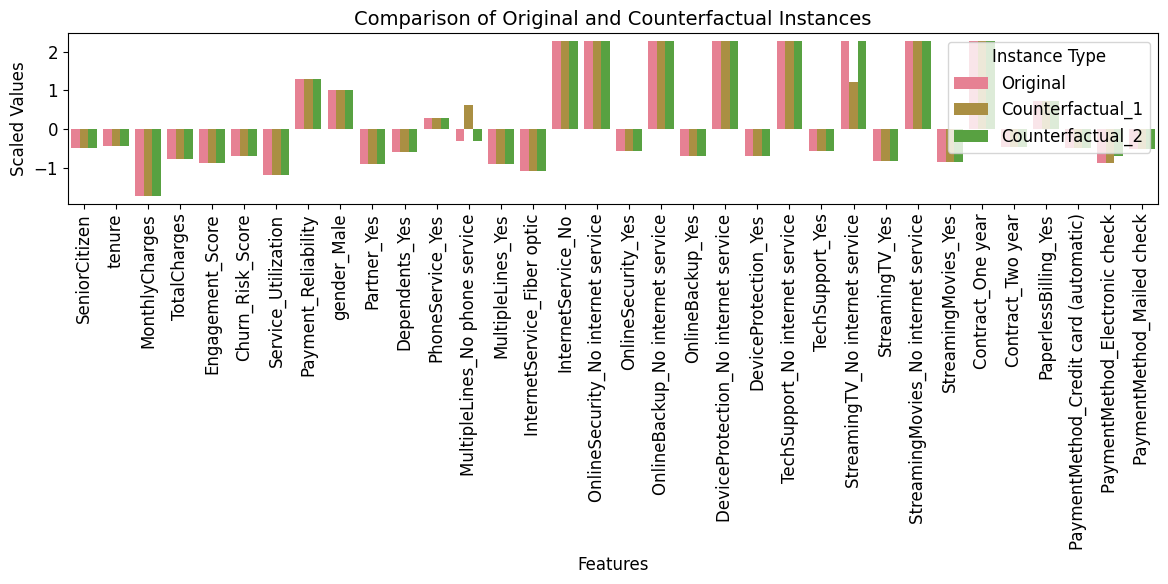

In [18]:
import dice_ml
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 12: COUNTERFACTUAL EXPLANATIONS (DICE-ML) ===
print("\n" + "="*50)
print("STEP 12: COUNTERFACTUAL EXPLANATIONS")
print("="*50)

try:
    print("Generating counterfactual explanations...")

    # Prepare data for DICE
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # Convert back to pandas DataFrame and ensure all features are present
    data_for_dice = pd.DataFrame(X_scaled_res, columns=X.columns)
    data_for_dice['target'] = y_res  # Add target column

    # Identify continuous features (numerical columns only)
    continuous_features = data_for_dice.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
    continuous_features = [f for f in continuous_features if f != 'target']  # Exclude target

    # Create DICE data object
    dice_data = dice_ml.Data(dataframe=data_for_dice,
                            continuous_features=continuous_features,
                            outcome_name='target')

    # Create DICE model
    dice_model = dice_ml.Model(model=final_model, backend="sklearn")

    # Create DICE explainer
    dice_explainer = dice_ml.Dice(dice_data, dice_model, method="random")

    # Scale query instances to match data_for_dice
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)  # Pastikan scaler sesuai dengan X_scaled_res
    query_instances = pd.DataFrame(X_test_scaled, columns=X.columns).head(3)

    # Generate counterfactuals for a few test instances
    counterfactuals = dice_explainer.generate_counterfactuals(query_instances, total_CFs=2, desired_class=1)

    # Display results
    print("\n✓ Counterfactual explanations generated")
    print("\nOriginal instance (scaled):")
    print(query_instances.iloc[0])
    print("\nCounterfactual examples:")
    if hasattr(counterfactuals.cf_examples_list[0], 'final_cfs_df'):
        cf_df = counterfactuals.cf_examples_list[0].final_cfs_df
        print(cf_df.head())
    else:
        print("No counterfactual examples found")

    # Visualization for journal
    plt.figure(figsize=(12, 6))
    original_instance = query_instances.iloc[0]
    data_to_plot = pd.DataFrame({
        'Feature': original_instance.index,
        'Original': original_instance.values,
        'Counterfactual_1': cf_df.iloc[0].values[:-1],  # Exclude target
        'Counterfactual_2': cf_df.iloc[1].values[:-1]   # Exclude target
    })
    data_melted = data_to_plot.melt(id_vars='Feature', var_name='Type', value_name='Value')
    sns.barplot(x='Feature', y='Value', hue='Type', data=data_melted)
    plt.xticks(rotation=90)
    plt.title('Comparison of Original and Counterfactual Instances', fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Scaled Values', fontsize=12)
    plt.legend(title='Instance Type')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/plots/counterfactual_comparison_journal.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"⚠ Counterfactual explanation failed: {str(e)}")
    print("Continuing without counterfactual explanations...")


STEP 12: COUNTERFACTUAL EXPLANATIONS
Generating counterfactual explanations...


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]



✓ Counterfactual explanations generated

Original instance (scaled):
SeniorCitizen                           -0.487793
tenure                                  -0.438308
MonthlyCharges                          -1.712891
TotalCharges                            -0.771451
Engagement_Score                        -0.853308
Churn_Risk_Score                        -0.694180
Service_Utilization                     -1.168283
Payment_Reliability                      1.300168
gender_Male                              1.022980
Partner_Yes                             -0.885573
Dependents_Yes                          -0.588939
PhoneService_Yes                         0.291026
MultipleLines_No phone service          -0.291026
MultipleLines_Yes                       -0.885204
InternetService_Fiber optic             -1.079808
InternetService_No                       2.265024
OnlineSecurity_No internet service       2.265024
OnlineSecurity_Yes                      -0.558186
OnlineBackup_No internet servi

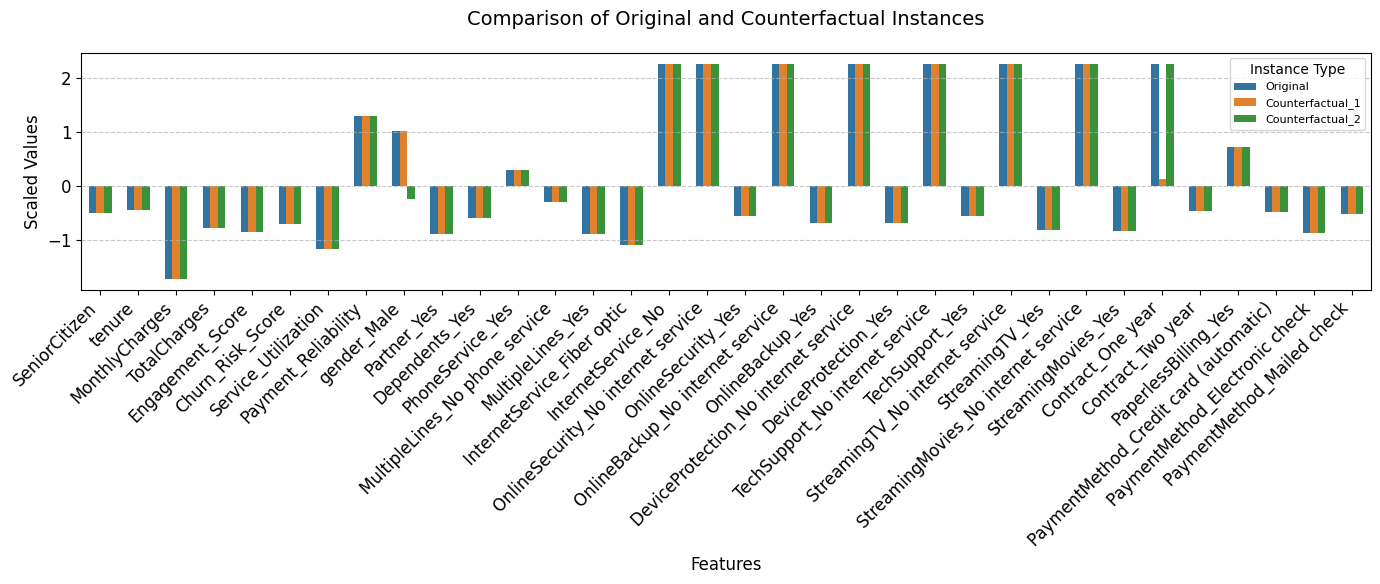

In [19]:
import dice_ml
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 12,5 simpy plot wkwk ===
print("\n" + "="*50)
print("STEP 12: COUNTERFACTUAL EXPLANATIONS")
print("="*50)

try:
    print("Generating counterfactual explanations...")

    # Prepare data for DICE
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # Convert back to pandas DataFrame and ensure all features are present
    data_for_dice = pd.DataFrame(X_scaled_res, columns=X.columns)
    data_for_dice['target'] = y_res  # Add target column

    # Identify continuous features (numerical columns only)
    continuous_features = data_for_dice.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
    continuous_features = [f for f in continuous_features if f != 'target']  # Exclude target

    # Create DICE data object
    dice_data = dice_ml.Data(dataframe=data_for_dice,
                            continuous_features=continuous_features,
                            outcome_name='target')

    # Create DICE model
    dice_model = dice_ml.Model(model=final_model, backend="sklearn")

    # Create DICE explainer
    dice_explainer = dice_ml.Dice(dice_data, dice_model, method="random")

    # Scale query instances to match data_for_dice
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)  # Pastikan scaler sesuai dengan X_scaled_res
    query_instances = pd.DataFrame(X_test_scaled, columns=X.columns).head(3)

    # Generate counterfactuals for a few test instances
    counterfactuals = dice_explainer.generate_counterfactuals(query_instances, total_CFs=2, desired_class=1)

    # Display results
    print("\n✓ Counterfactual explanations generated")
    print("\nOriginal instance (scaled):")
    print(query_instances.iloc[0])
    print("\nCounterfactual examples:")
    if hasattr(counterfactuals.cf_examples_list[0], 'final_cfs_df'):
        cf_df = counterfactuals.cf_examples_list[0].final_cfs_df
        print(cf_df.head())
    else:
        print("No counterfactual examples found")

   # Visualization for journal
    plt.figure(figsize=(14, 6))
    original_instance = query_instances.iloc[0]
    data_to_plot = pd.DataFrame({
        'Feature': original_instance.index,
        'Original': original_instance.values,
        'Counterfactual_1': cf_df.iloc[0].values[:-1],  # Exclude target
        'Counterfactual_2': cf_df.iloc[1].values[:-1]   # Exclude target
    })
    data_melted = data_to_plot.melt(id_vars='Feature', var_name='Type', value_name='Value')

    # Create bar plot with adjusted parameters
    sns.barplot(x='Feature', y='Value', hue='Type', data=data_melted,
                palette=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Distinct colors
                width=0.6)  # Adjusted bar width
    plt.xticks(rotation=45, ha='right')  # Rotate and align labels
    plt.title('Comparison of Original and Counterfactual Instances', fontsize=14, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Scaled Values', fontsize=12)
    plt.legend(title='Instance Type', title_fontsize=10, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add light grid
    plt.tight_layout()

    # Save and display
    plt.savefig(f'{OUTPUT_DIR}/plots/counterfactual_comparison_journal_clean_simply.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"⚠ Counterfactual explanation failed: {str(e)}")
    print("Continuing without counterfactual explanations...")

In [20]:

# === STEP 13: COMPREHENSIVE RESULTS SUMMARY ===
print("\n" + "="*50)
print("STEP 13: COMPREHENSIVE RESULTS SUMMARY")
print("="*50)

# Create comprehensive summary
summary_data = {
    'Dataset_Shape': df.shape,
    'Features_After_Engineering': X.shape[1],
    'Best_Model': best_model,
    'Best_CV_ROC_AUC': cv_results[best_model].mean() if best_model in cv_results else 'N/A',
    'Test_Accuracy': test_metrics['accuracy'],
    'Test_Precision': test_metrics['precision'],
    'Test_Recall': test_metrics['recall'],
    'Test_F1': test_metrics['f1'],
    'Test_ROC_AUC': test_metrics['roc_auc'],
    'Total_Runtime': f"{(datetime.now() - datetime.strptime(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')).total_seconds():.2f} seconds"
}

print("FINAL ANALYSIS SUMMARY")
print("=" * 60)
for key, value in summary_data.items():
    print(f"{key.replace('_', ' ').title():<25}: {value}")

# Save all results to Excel
try:
    with pd.ExcelWriter(f"{OUTPUT_DIR}/comprehensive_results.xlsx", engine='xlsxwriter') as writer:
        if cv_results:
            model_comparison = pd.DataFrame({
                'Model': list(cv_results.keys()),
                'Mean_ROC_AUC': [scores.mean() for scores in cv_results.values()],
                'Std_ROC_AUC': [scores.std() for scores in cv_results.values()],
                'Min_ROC_AUC': [scores.min() for scores in cv_results.values()],
                'Max_ROC_AUC': [scores.max() for scores in cv_results.values()]
            }).sort_values('Mean_ROC_AUC', ascending=False)
            model_comparison.to_excel(writer, sheet_name='Model_Comparison', index=False)

        # Test metrics
        test_metrics_df = pd.DataFrame([test_metrics])
        test_metrics_df.to_excel(writer, sheet_name='Test_Metrics', index=False)

        # Feature importance (if available)
        if not importance_df.empty:
            importance_df.to_excel(writer, sheet_name='Feature_Importance', index=False)

        # Hyperparameter tuning results
        tuning_df.to_excel(writer, sheet_name='Hyperparameter_Tuning', index=False)

        # Summary
        summary_df = pd.DataFrame([summary_data])
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

        # TAMBAHAN: Comparative results
        comparative_results_df.to_excel(writer, sheet_name='Comparative_Results', index=False)

        print("✓ Comprehensive results saved to Excel")

except Exception as e:
    print(f"⚠ Error saving to Excel: {str(e)}")



STEP 13: COMPREHENSIVE RESULTS SUMMARY
FINAL ANALYSIS SUMMARY
Dataset Shape            : (7043, 24)
Features After Engineering: 34
Best Model               : CatBoost
Best Cv Roc Auc          : 0.9408122800714469
Test Accuracy            : 0.8577502899110939
Test Precision           : 0.8560431100846805
Test Recall              : 0.860015467904099
Test F1                  : 0.8580246913580247
Test Roc Auc             : 0.938701855550814
Total Runtime            : 0.31 seconds
✓ Comprehensive results saved to Excel


In [21]:

# === STEP 14: FINAL RECOMMENDATIONS ===
print("\n" + "="*50)
print("STEP 14: FINAL RECOMMENDATIONS")
print("="*50)

print("BUSINESS RECOMMENDATIONS:")
print("-" * 40)
print("1. MODEL DEPLOYMENT:")
print(f"   - Deploy {best_model} model with {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"   - Expected precision: {test_metrics['precision']:.4f}")
print(f"   - Expected recall: {test_metrics['recall']:.4f}")

print("\n2. FEATURE INSIGHTS:")
if not importance_df.empty:
    top_3_features = importance_df.head(3)['feature'].tolist()
    print(f"   - Focus on top predictive features: {', '.join(top_3_features[:3])}")
else:
    print("   - Feature importance analysis not available for selected model")

print("\n3. MODEL MONITORING:")
print("   - Monitor model performance monthly")
print("   - Retrain when performance drops below 0.80 ROC-AUC")
print("   - Track prediction distribution for data drift")

print("\n4. BUSINESS ACTIONS:")
print("   - Implement targeted retention campaigns for high-risk customers")
print("   - Focus on improving customer engagement metrics")
print("   - Consider pricing strategy adjustments for at-risk segments")

print("\n" + "="*80)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"All outputs saved to: {OUTPUT_DIR}/")
print("Files generated:")
print("- Models: final_model.pkl, scaler.pkl")
print("- Data: feature_importance.csv, hyperparameter_tuning_results.csv, cv_metrics_per_fold.csv, comparative_model_results.csv")
print("- Plots: target_distribution.png, correlation_matrix.png, model_comparison.png, confusion_matrix_no_feature_engineering.png, confusion_matrix_feature_engineering.png,")
print("         confusion_matrix_feature_engineering_smote.png, ..., comparative_model_performance.png")
print("         confusion_matrix.png, roc_curve.png, precision_recall_curve.png,")
print("         calibration_curve.png, feature_importance.png, shap_summary.png, shap_bar.png")
print("- Summary: comprehensive_results.xlsx")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


STEP 14: FINAL RECOMMENDATIONS
BUSINESS RECOMMENDATIONS:
----------------------------------------
1. MODEL DEPLOYMENT:
   - Deploy CatBoost model with 0.9387 ROC-AUC
   - Expected precision: 0.8560
   - Expected recall: 0.8600

2. FEATURE INSIGHTS:
   - Focus on top predictive features: tenure, InternetService_Fiber optic, Contract_Two year

3. MODEL MONITORING:
   - Monitor model performance monthly
   - Retrain when performance drops below 0.80 ROC-AUC
   - Track prediction distribution for data drift

4. BUSINESS ACTIONS:
   - Implement targeted retention campaigns for high-risk customers
   - Focus on improving customer engagement metrics
   - Consider pricing strategy adjustments for at-risk segments

ANALYSIS COMPLETED SUCCESSFULLY!
All outputs saved to: rill_final_enhanced/
Files generated:
- Models: final_model.pkl, scaler.pkl
- Data: feature_importance.csv, hyperparameter_tuning_results.csv, cv_metrics_per_fold.csv, comparative_model_results.csv
- Plots: target_distribution.p

In [22]:
# !pip install xlsxwriternkjkmkmkmkkkkkkkkkk

In [23]:
# yey scopus Q2 i hope :3